# Self-driving car Nanodegree - Term 1

## Project 0: **Finding Lane Lines on the Road** 
***
In this project, We will develop an algorithm pipeline to detect lane lines in images. In addition to implementing code, there is a brief [writeup](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Finding%20Lane%20Lines/writeup.md)

## Helper functions

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

def color_selection(image, r_threshold, g_threshold, b_threshold):

    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    ##color selection
    color_select = np.copy(image)

    # Define color selection criteria
    red_threshold = r_threshold
    green_threshold = g_threshold
    blue_threshold =  b_threshold

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])

    color_select[thresholds] = [0,0,0]
    
     ##region selection
    
    return color_select

#grayscale is hsl
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def hsv_conversion(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)



def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



### First attempt

In [7]:
###CONFIGURATION###
red_threshold = 200
green_threshold = 200
blue_threshold = 200
gaussian_kernel_size = 11
canny_low_threshold = 50
canny_high_threshold = 150
hough_rho = 2                 # distance resolution in pixels of the Hough grid
hough_theta = (np.pi)/180     # angular resolution in radians of the Hough grid
hough_threshold = 15          # minimum number of votes (intersections in Hough grid cell)
hough_min_line_len = 40       # minimum number of pixels making up a line
hough_max_line_gap = 20       # maximum gap in pixels between connectable line segments
###CONFIGURATION###

def pipeline_1st_attempt(image, save_location):
    #1. color selection
    #2. grayscale 
    #3. gaussian smoothing
    #4. canny
    #5. image mask
    #6. Hough transform
    
    # retain selected white lane lines
    img_color = color_selection(image, red_threshold, green_threshold, blue_threshold)
    cv2.imwrite(save_location + "/img_color.jpg", img_color)
    
    #convert to grayscale
    img_grayscale = grayscale(img_color)
    cv2.imwrite(save_location + "/img_grayscale.jpg", img_grayscale)

    #define a kernel size and apply gaussion smoothing
    img_gaussian = gaussian_blur(img_grayscale, gaussian_kernel_size)
    cv2.imwrite(save_location + "/img_gaussian.jpg", img_gaussian)

    
    #canny edge detection
    img_canny = canny(img_gaussian, canny_low_threshold, canny_high_threshold)
    cv2.imwrite(save_location + "/img_canny.jpg", img_canny)

    
    # region of interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),
                          (450, 290), 
                          (490, 290), 
                          (imshape[1],imshape[0])]], 
                            dtype=np.int32)
    img_region = region_of_interest(img_canny,vertices)
    cv2.imwrite(save_location + "/img_region.jpg", img_region)


    # Define the Hough transform parameters => output is matrix NxMxL
    # Make a blank the same size as our image to draw on
    img_hough_lines = hough_lines(img_region, 
                                  hough_rho, hough_theta, hough_threshold, 
                                  hough_min_line_len, hough_max_line_gap) 
    cv2.imwrite(save_location + "/img_hough_lines.jpg", img_hough_lines)

    # Draw the lines on the edge image
    result = weighted_img(img_hough_lines, image, α=0.8, β=1., λ=0.)
    cv2.imwrite(save_location + "/result.jpg", result)

    return result


image = mpimg.imread('test_images/solidWhiteRight.jpg')
print(image.shape)
result = pipeline_1st_attempt(image, "images_output_1st_attempt")   

(540, 960, 3)


In [ ]:
### CONFIGURATION ###
red_threshold = 200
green_threshold = 200
blue_threshold = 200
gaussian_kernel_size = 11
canny_low_threshold = 50
canny_high_threshold = 150
hough_rho = 2                 # distance resolution in pixels of the Hough grid
hough_theta = (np.pi)/180     # angular resolution in radians of the Hough grid
hough_threshold = 15          # minimum number of votes (intersections in Hough grid cell)
hough_min_line_len = 40       # minimum number of pixels making up a line
hough_max_line_gap = 20       # maximum gap in pixels between connectable line segments
### CONFIGURATION ###

def pipeline_2nd_attempt(image, save_location):
    #1. Converting image to grayscale
    #2. Applying a Gaussian blur to the image
    #3. Applying Canny edge detection
    #4. Masking the image so that only the region of interest is processed
    #5. Running the Hough transform to identify lines
    #6. Converting those lines into straight lines
    #7. Smoothing the result with a moving average filter
    #8 Plotting the lines on top of the image
    
    # retain selected white lane lines
    img_color = color_selection(image, red_threshold, green_threshold, blue_threshold)
    cv2.imwrite(save_location + "/img_color.jpg", img_color)
    
    #convert to grayscale
    img_grayscale = grayscale(img_color)
    cv2.imwrite(save_location + "/img_grayscale.jpg", img_grayscale)

    #define a kernel size and apply gaussion smoothing
    img_gaussian = gaussian_blur(img_grayscale, gaussian_kernel_size)
    cv2.imwrite(save_location + "/img_gaussian.jpg", img_gaussian)

    
    #canny edge detection
    img_canny = canny(img_gaussian, canny_low_threshold, canny_high_threshold)
    cv2.imwrite(save_location + "/img_canny.jpg", img_canny)

    
    # region of interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),
                          (450, 290), 
                          (490, 290), 
                          (imshape[1],imshape[0])]], 
                            dtype=np.int32)
    img_region = region_of_interest(img_canny,vertices)
    cv2.imwrite(save_location + "/img_region.jpg", img_region)


    # Define the Hough transform parameters => output is matrix NxMxL
    # Make a blank the same size as our image to draw on
    img_hough_lines = hough_lines(img_region, 
                                  hough_rho, hough_theta, hough_threshold, 
                                  hough_min_line_len, hough_max_line_gap) 
    cv2.imwrite(save_location + "/img_hough_lines.jpg", img_hough_lines)

    # Draw the lines on the edge image
    result = weighted_img(img_hough_lines, image, α=0.8, β=1., λ=0.)
    cv2.imwrite(save_location + "/result.jpg", result)

    return result


image = mpimg.imread('test_images/solidWhiteRight.jpg')
result = pipeline_2nd_attempt(image, "images_output_1st_attempt")   

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline_first_attempt) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 15.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline_first_attempt)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  1%|          | 4/682 [00:00<00:43, 15.77it/s]

TypeError: 'NoneType' object is not iterable

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_yellow is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white_gray is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_gaussian is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_canny is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_region is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_hough_lines is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
 result is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  0%|          | 0/251 [00:00<?, ?it/s]

image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_yellow is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white_gray is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_gaussian is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_canny is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_region is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_hough_lines is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
 result is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)



  0%|          | 1/251 [00:00<03:17,  1.27it/s]

image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_yellow is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white_gray is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_gaussian is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_canny is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_region is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_hough_lines is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
 result is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)



  1%|          | 2/251 [00:01<03:26,  1.21it/s]

image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_yellow is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
img_white_gray is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_gaussian is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_canny is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_region is: <class 'numpy.ndarray'> with dimensions: (720, 1280)
img_hough_lines is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
 result is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)



  1%|          | 3/251 [00:02<03:27,  1.20it/s]

TypeError: 'NoneType' object is not iterable

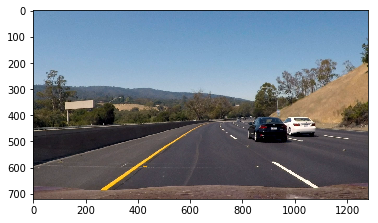

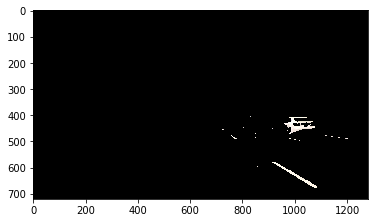

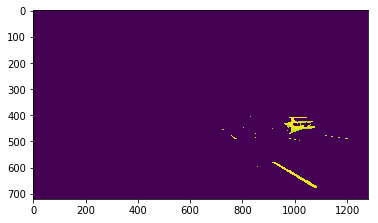

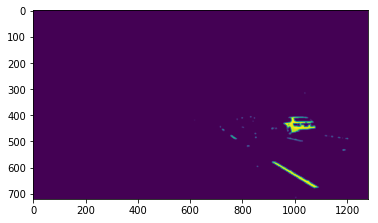

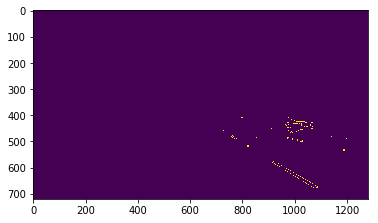

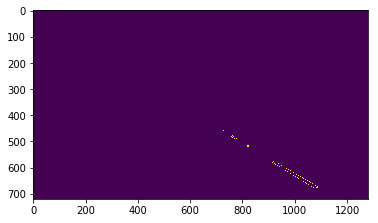

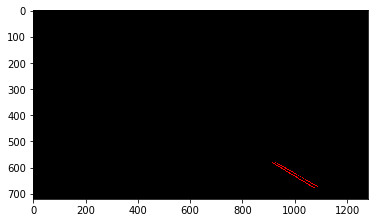

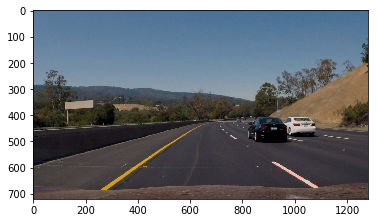

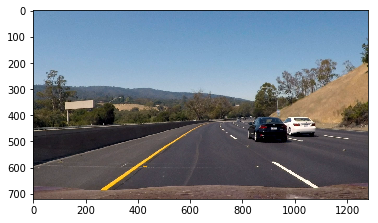

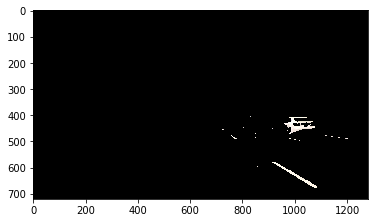

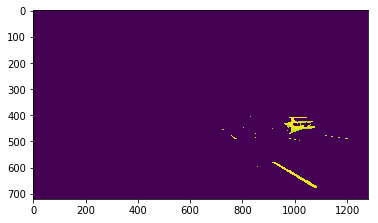

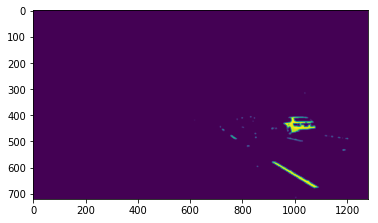

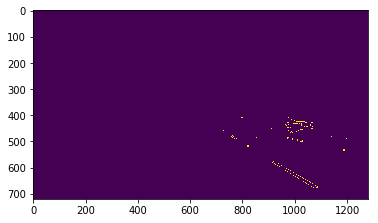

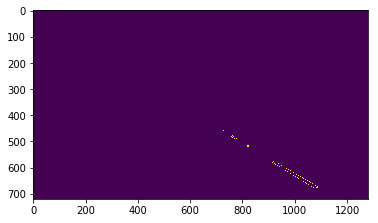

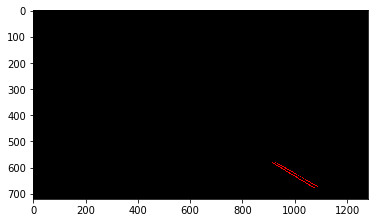

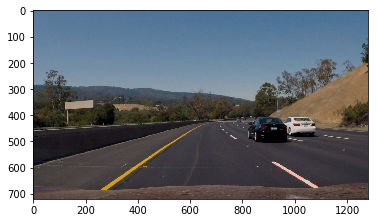

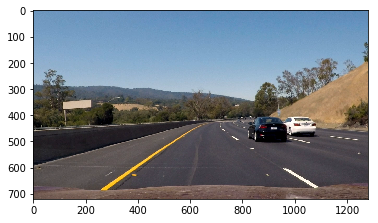

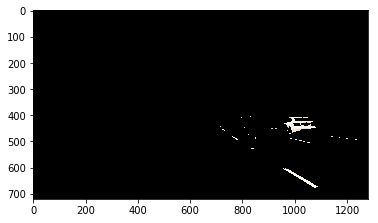

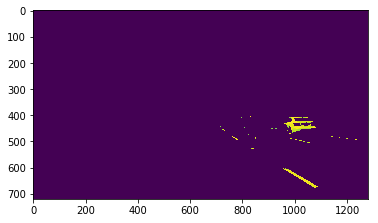

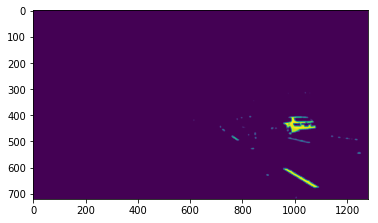

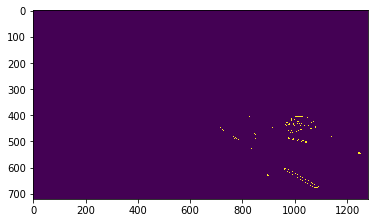

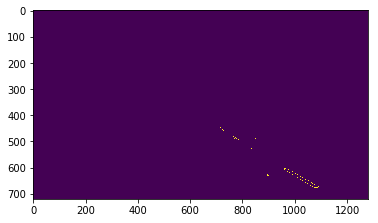

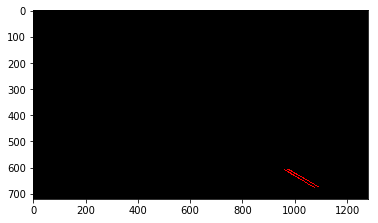

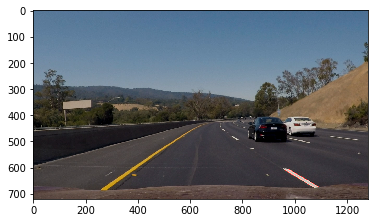

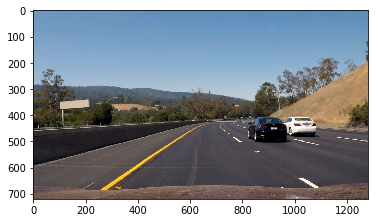

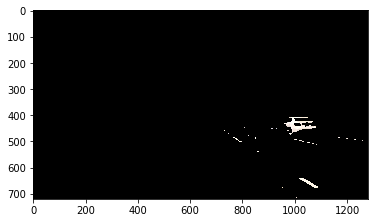

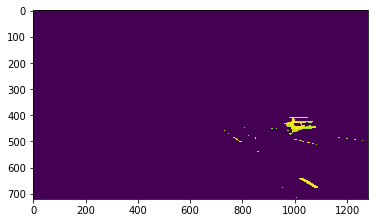

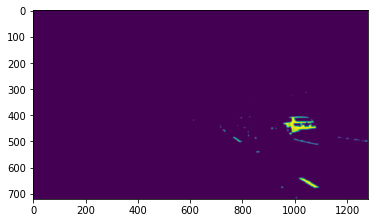

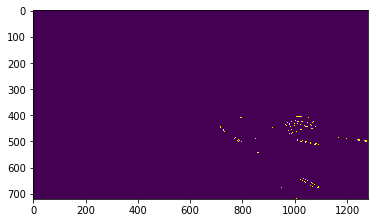

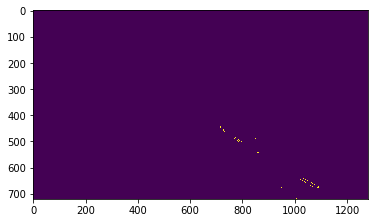

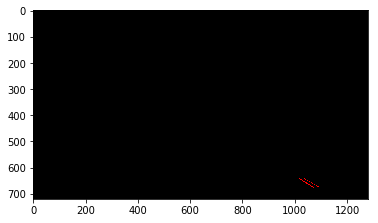

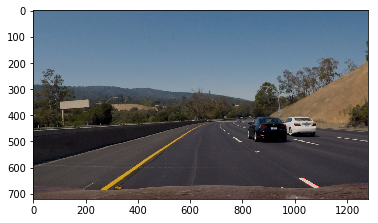

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(pipeline_first_attempt)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))